In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os


class Segmentator:
    def __init__(self, img):
        self.img = img
    
    def convert_to_HSV(self):
        image_hsv = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        image_h, image_s, image_v = cv2.split(image_hsv)
        return image_v
    
    def gaussian_blur(self, gray: np.ndarray, ksize: int = 5) -> np.ndarray:
        return cv2.GaussianBlur(gray, (ksize, ksize), 0)
    
    def binarize(self, image: np.ndarray) -> np.ndarray:
        _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return binary_image

    def closing(self, binary_image: np.ndarray, ksize: int = 3) -> np.ndarray:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ksize, ksize))
        closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
        return closed_image
    
    def opening(self, binary_image: np.ndarray, ksize: int = 3) -> np.ndarray:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ksize, ksize))
        opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
        return opened_image
    
    
    def find_contours(self, binary_image: np.ndarray):
        binary_inverted = 255 - binary_image
        contours, hierarchy = cv2.findContours(binary_inverted, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)          
        return contours
    
    def filter_license_plate_contours(self, contours, binary_image):
        img_h, img_w = binary_image.shape
        filtered_boxes = []

        min_aspect = 0.2    # relación de aspecto mínima (ancho/alto)
        max_aspect = 1.0    # relación de aspecto máxima

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h
            aspect_ratio = w / h

            # Filtrar por área, aspecto y que no toque bordes laterales
            if (min_aspect <= aspect_ratio <= max_aspect and
                x > 0 and (x + w) < img_w):   # evita contornos pegados a los bordes
                filtered_boxes.append((x, y, w, h))

        # Ordenar de izquierda a derecha
        filtered_boxes = sorted(filtered_boxes, key=lambda b: b[0])

        # Si hay más de 7 contornos, seleccionar los 7 más grandes en área
        if len(filtered_boxes) > 7:
            filtered_boxes = sorted(filtered_boxes, key=lambda b: b[2]*b[3], reverse=True)[:7]
            # Re-ordenar de izquierda a derecha
            filtered_boxes = sorted(filtered_boxes, key=lambda b: b[0])
        
        return filtered_boxes

In [ ]:
crops_folder = "Crops"
crop_images = [f for f in os.listdir(crops_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

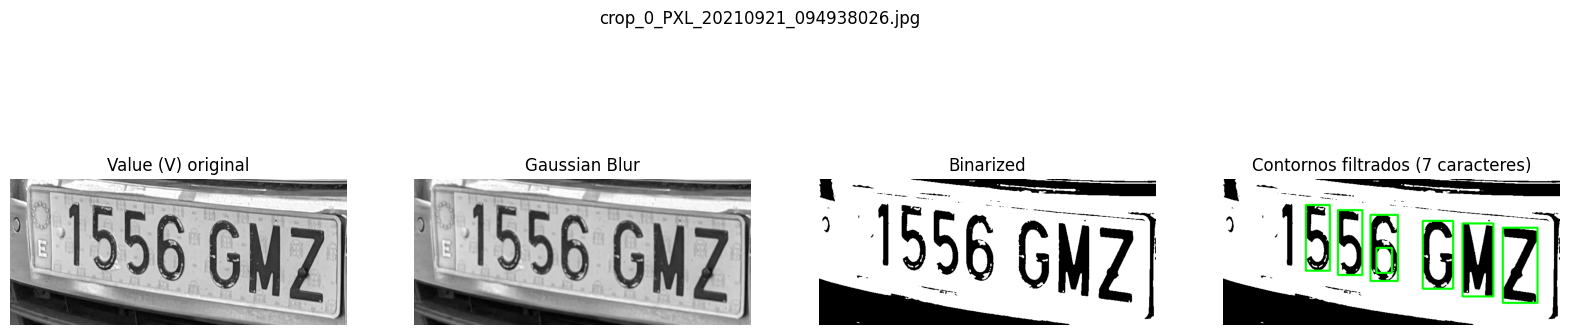

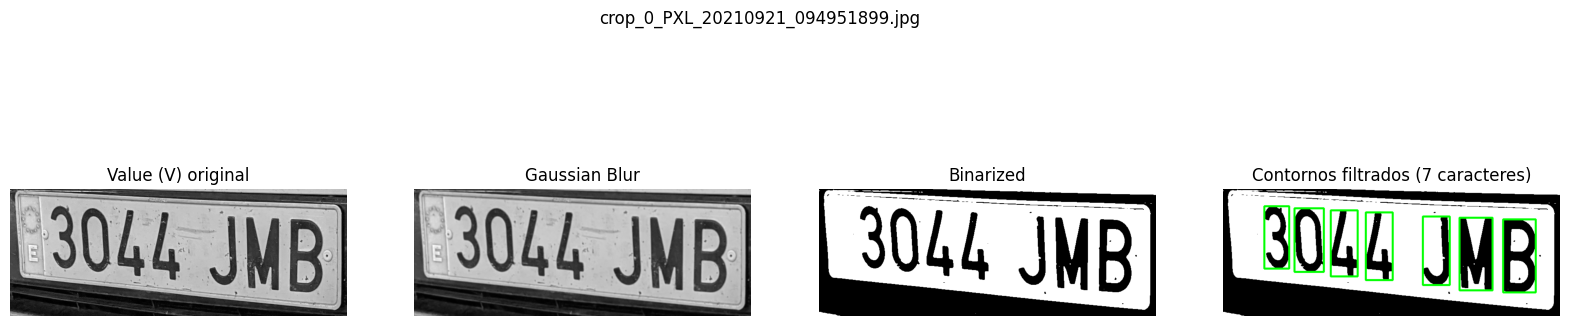

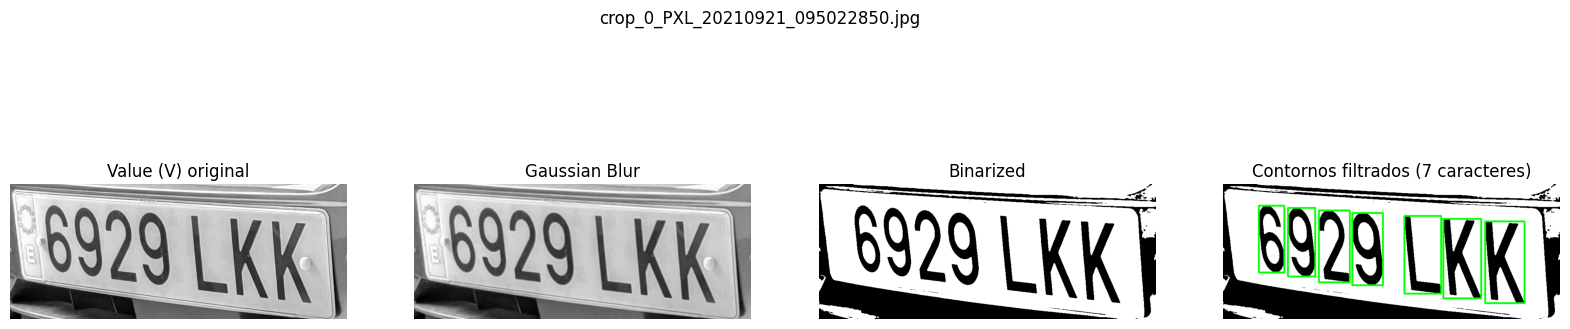

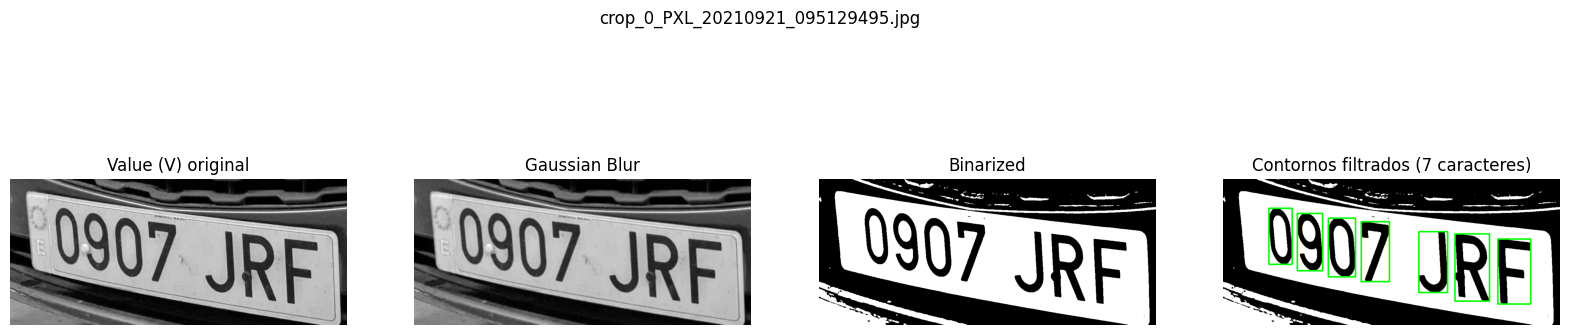

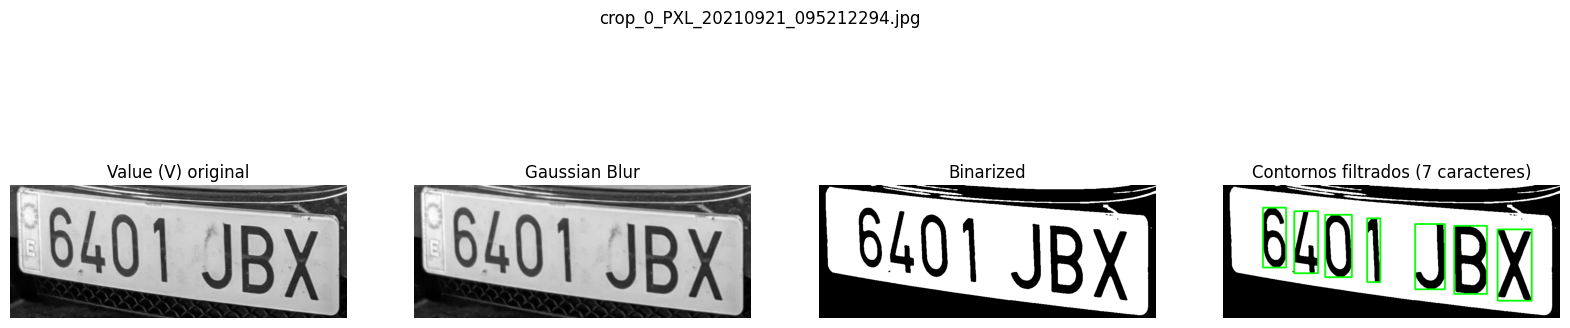

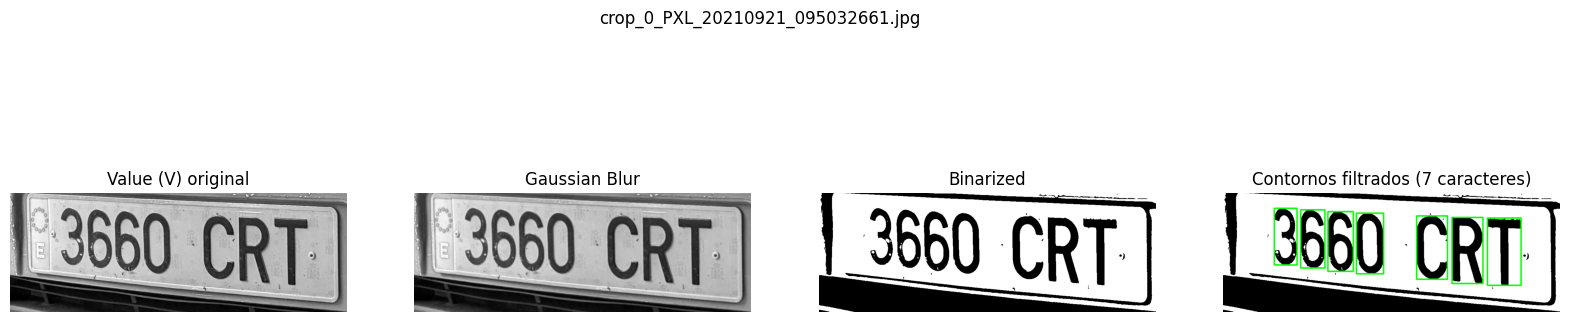

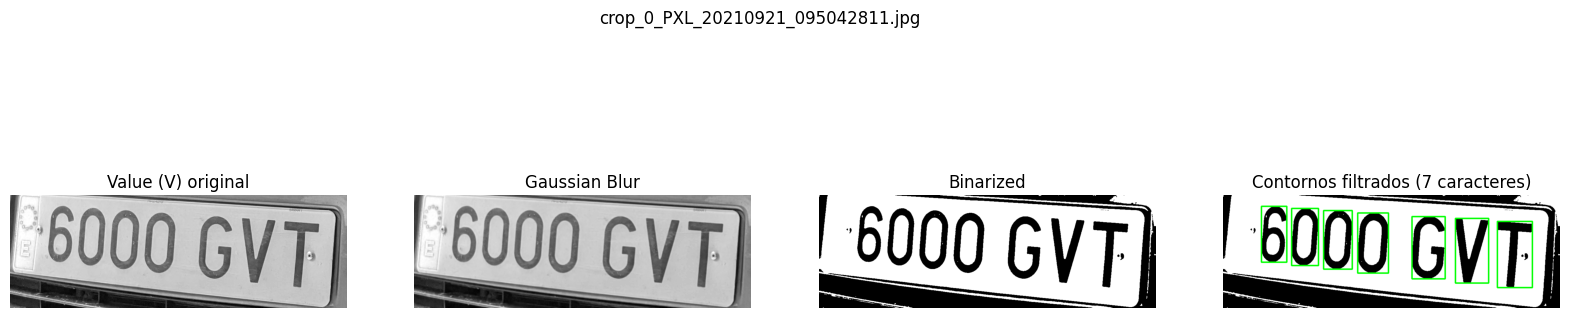

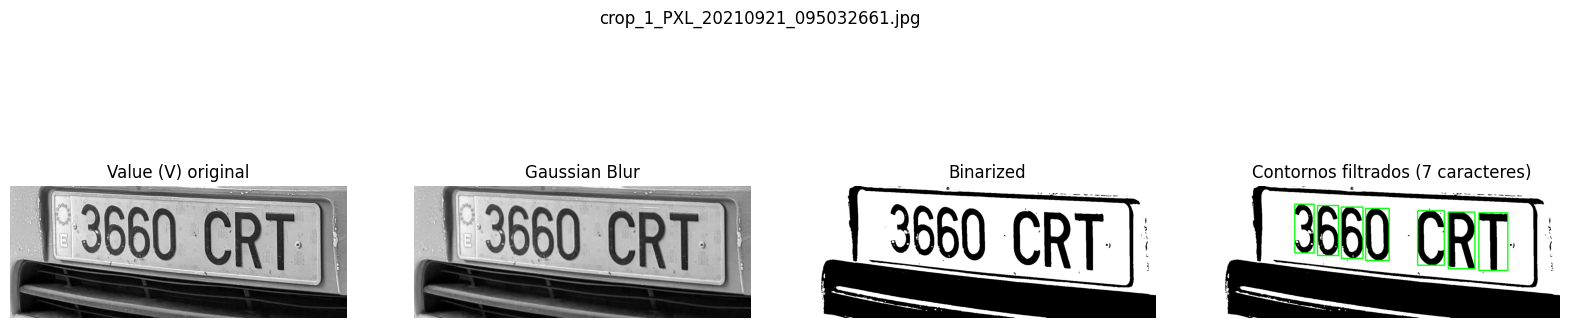

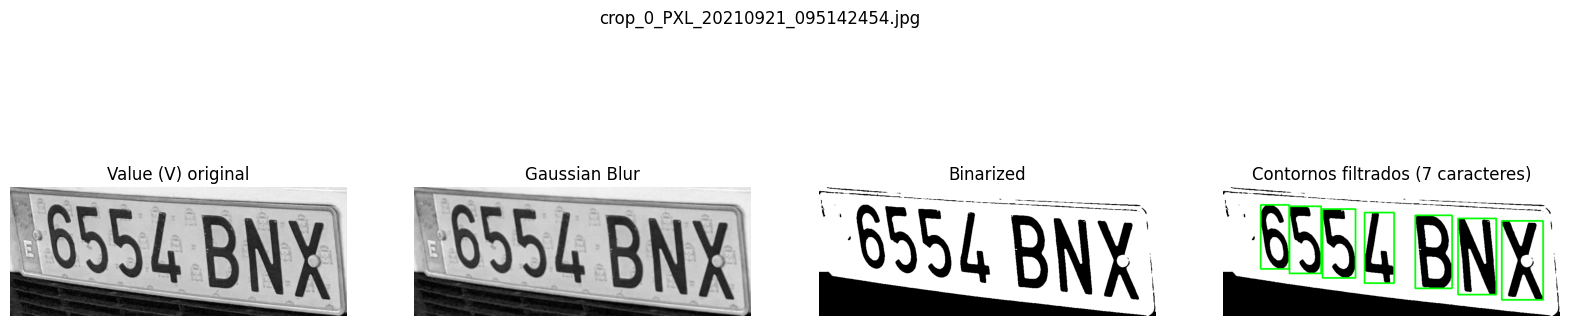

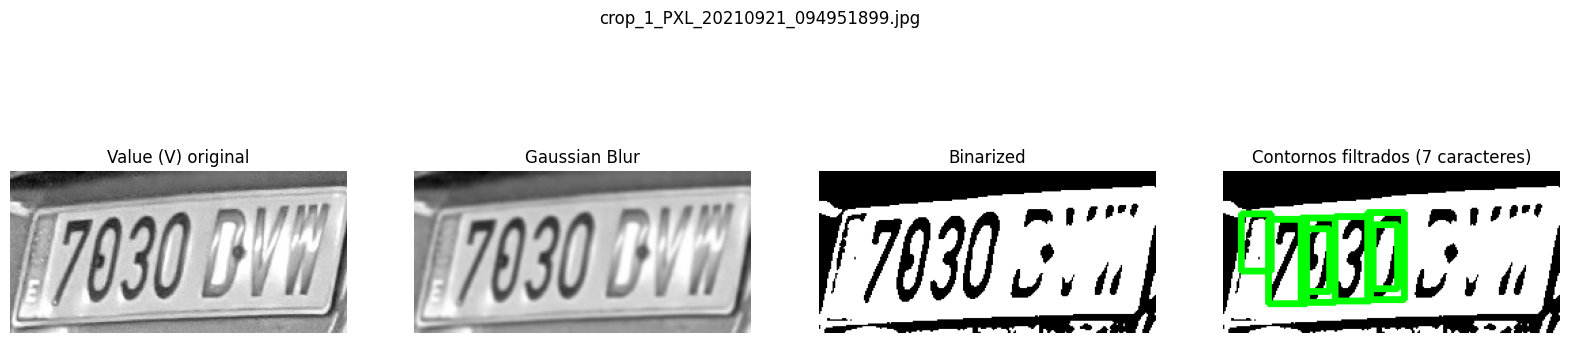

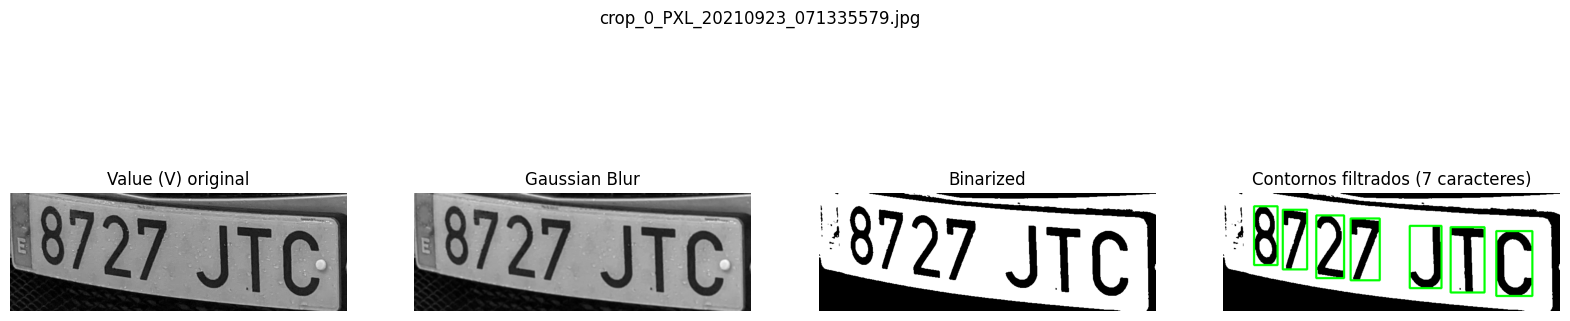

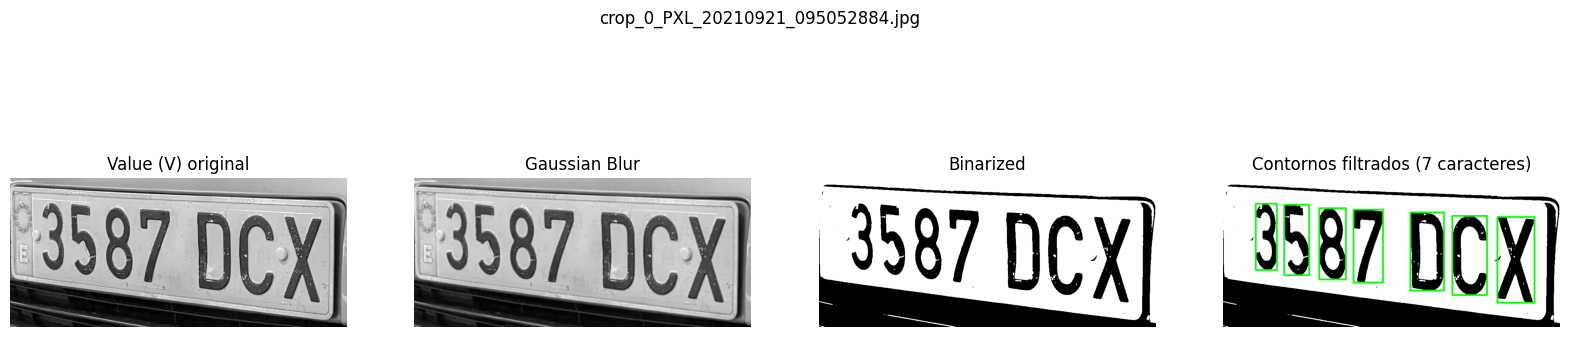

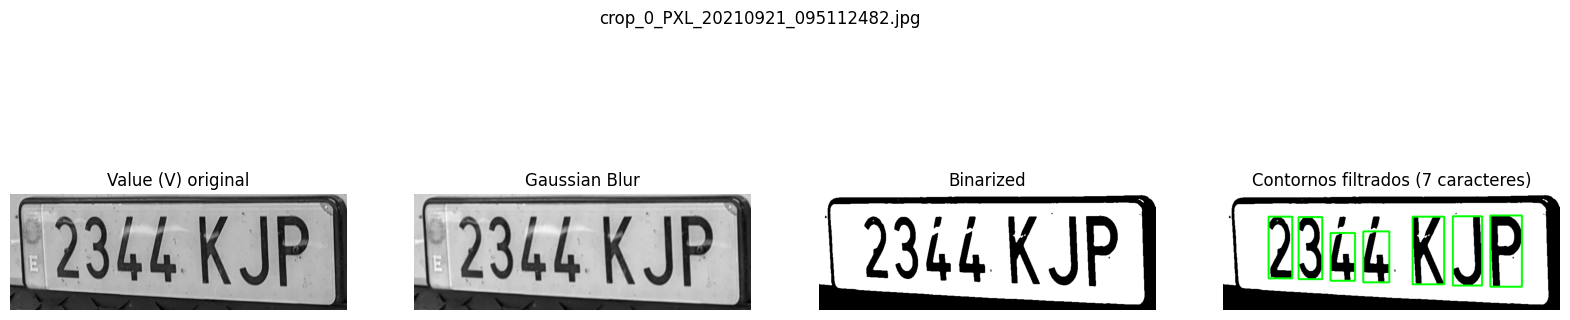

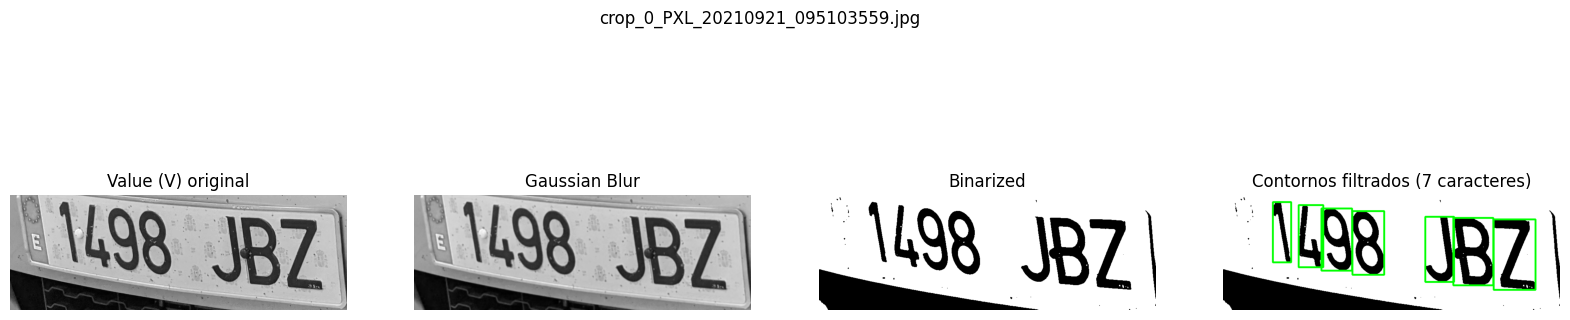

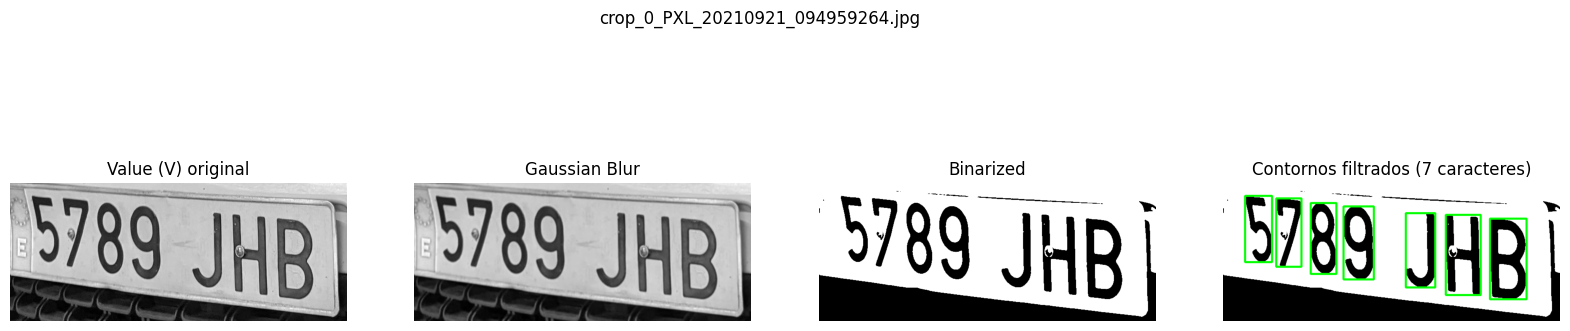

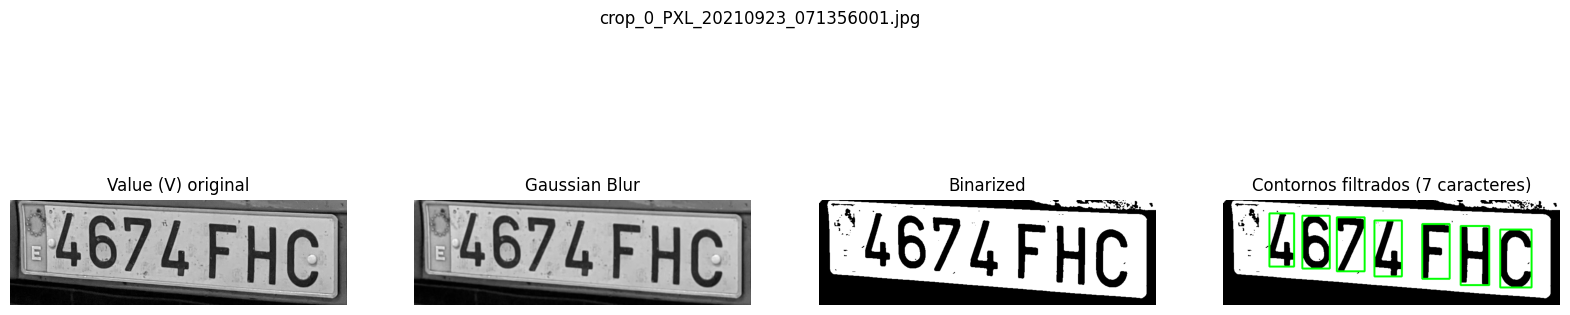

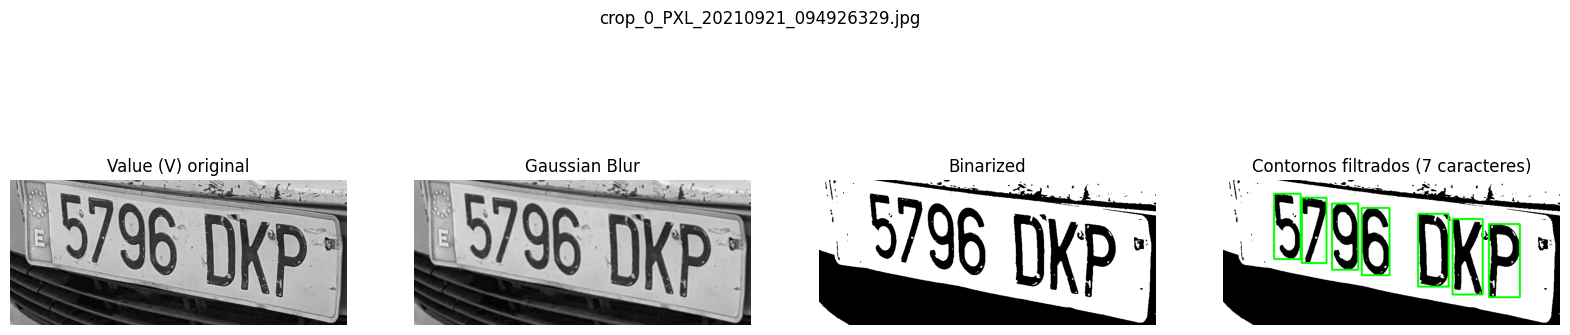

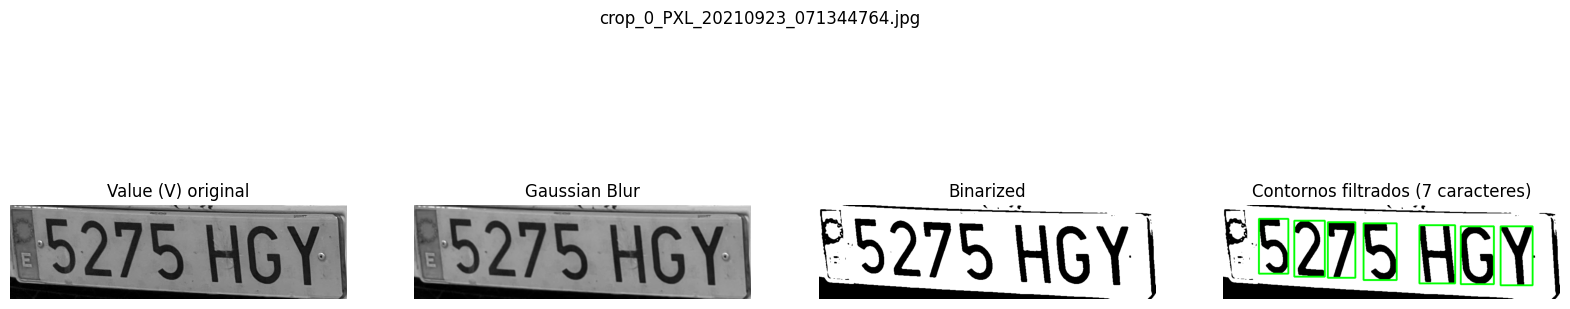

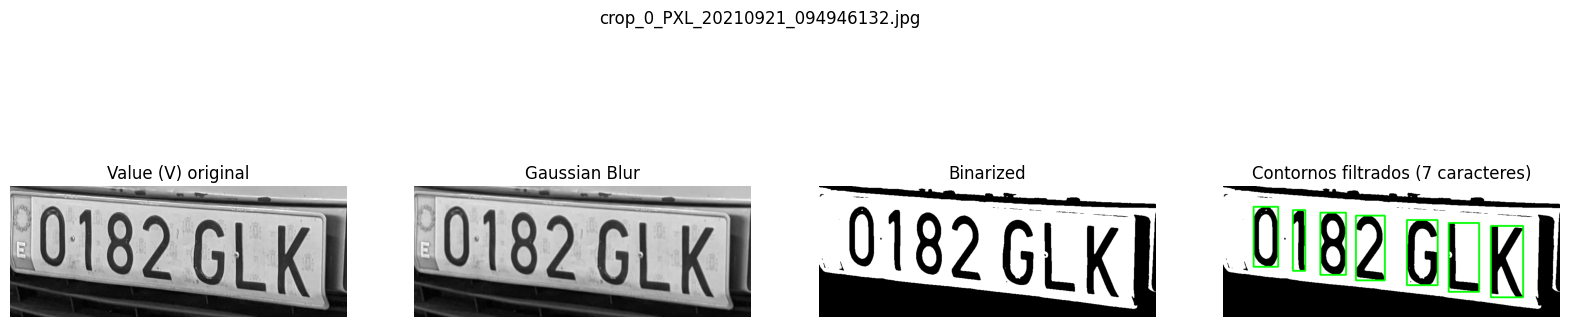

In [37]:
for crop_name in crop_images:
    image_path = os.path.join(crops_folder, crop_name)
    img = cv2.imread(image_path)
    
    segmentador = Segmentator(img)
    
    # --- 1. Canal V ---
    image_v = segmentador.convert_to_HSV()
    
    # --- 2. Median Blur ---
    #image_v_blurred = segmentador.median_blur(image_v, ksize=5)
    image_v_blurred = segmentador.gaussian_blur(image_v, ksize=5)
    
    # --- 3. Binarizar ---
    binary_image = segmentador.binarize(image_v_blurred)
    
    # --- 4. Contornos ---
    contours = segmentador.find_contours(binary_image)
    
    # --- 5. Filtrar contornos ---
    boxes = segmentador.filter_license_plate_contours(contours, binary_image)
    
    # --- 6. Dibujar contornos filtrados ---
    output = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    for x, y, w, h in boxes:
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    
    # --- 7. Visualización ---
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,4,1)
    plt.imshow(image_v, cmap='gray')
    plt.title("Value (V) original")
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(image_v_blurred, cmap='gray')
    plt.title("Gaussian Blur")
    plt.axis('off')
    
    plt.subplot(1,4,3)
    plt.imshow(binary_image, cmap='gray')
    plt.title("Binarized")
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(output)
    plt.title(f"Contornos filtrados ({len(boxes)} caracteres)")
    plt.axis('off')
    
    plt.suptitle(crop_name)
    plt.show()